# Reusable Components with LineaPy

This tutorial will use a typical data science workflow, including the following steps.

1. reading raw data
1. doing exploratory data analysis
1. doing feature engineering
1. training an ML model
1. evaluating model performance

As our example to demonstrate how to use `LineaPy` to create reusable components and how we can reuse these components.

## Part 1: Go Through a Typical Data Scientist Workflow

Let's use [Sloan Digital Sky Survey Classification](https://www.kaggle.com/datasets/lucidlenn/sloan-digital-sky-survey) as our example. 
The data consists of 10,000 observations of space taken by the [SDSS](http://www.sdss.org/dr14/). 
Every observation is described by 17 feature columns and 1 class column, identifying it as a star, galaxy, or quasar.
Our example is training a model to predict the object class(galaxy, star, or quasar) based on the 17 features.

Detailed dataset descriptions are available at [Sloan Digital Sky Survey Classification](https://www.kaggle.com/datasets/lucidlenn/sloan-digital-sky-survey).
More background education about galaxies is available at [UMD ASTR620 class](https://www.astro.umd.edu/~richard/ASTRO620/index_fall2015.html).

### Importing Libraries and Setup

In [1]:
#NBVAL_SKIP
!pip -q install lineapy~=0.2 scikit-learn pandas matplotlib seaborn numpy tensorflow

In [2]:
#NBVAL_SKIP
%load_ext lineapy

/home/mingjerli/miniconda3/envs/lineapy39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import importlib
import sklearn
import importlib.util
import sys
import tempfile
from importlib.abc import Loader
from pathlib import Path

%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rcParams['figure.dpi']=240

In [4]:
def flowchart(graph, dpi = 240, title=""):
    """
    Draw mermaid diagram in notebook
    
    We use this to visualize some diagrams in the rest of the  notebook, it's not part of LineaPy
    """
    import base64
    import requests, io
    from PIL import Image
    import matplotlib.pyplot as plt

    graphbytes = graph.encode("ascii")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    img = Image.open(io.BytesIO(requests.get('https://mermaid.ink/img/' + base64_string).content))
    plt.rcParams['figure.dpi']=dpi
    plt.imshow(img)
    plt.grid(None)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)          

### Load Dataset

Load Data and Save Artifact as CheckPoint

In [5]:
# NBVAL_IGNORE_OUTPUT
url = "https://raw.githubusercontent.com/LineaLabs/lineapy/main/examples/use_cases/creating_reusable_components/data/Skyserver_SQL2_27_2018%206_51_39%20PM.csv"
sdss_df = pd.read_csv(url)
lineapy.save(sdss_df, 'raw_data')

LineaArtifact(name='raw_data', _version=10)

### Explorer the Dataset

The dataset has 10000 examples, 17 feature columns, and one target column. 8 of the 17 features are 64-bit integers, one feature is an unsigned 64-bit integer, 8 are 64-bit floats, and the target column is of the type object. 

In [6]:
# NBVAL_IGNORE_OUTPUT
sdss_df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [7]:
# NBVAL_IGNORE_OUTPUT
sdss_df.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.237650e+18,175.529987,14.836148,18.619355,17.371931,16.840963,16.583579,16.422833,981.034800,301.0,3.648700,302.380100,1.645022e+18,0.143726,1460.986400,52943.533300,353.069400
std,0.000000e+00,47.783439,25.212207,0.828656,0.945457,1.067764,1.141805,1.203188,273.305024,0.0,1.666183,162.577763,2.013998e+18,0.388774,1788.778371,1511.150651,206.298149
min,1.237650e+18,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,308.000000,301.0,1.000000,11.000000,2.995780e+17,-0.004136,266.000000,51578.000000,1.000000
25%,1.237650e+18,157.370946,-0.539035,18.178035,16.815100,16.173333,15.853705,15.618285,752.000000,301.0,2.000000,184.000000,3.389248e+17,0.000081,301.000000,51900.000000,186.750000
50%,1.237650e+18,180.394514,0.404166,18.853095,17.495135,16.858770,16.554985,16.389945,756.000000,301.0,4.000000,299.000000,4.966580e+17,0.042591,441.000000,51997.000000,351.000000
75%,1.237650e+18,201.547279,35.649397,19.259232,18.010145,17.512675,17.258550,17.141447,1331.000000,301.0,5.000000,414.000000,2.881300e+18,0.092579,2559.000000,54468.000000,510.000000
max,1.237650e+18,260.884382,68.542265,19.599900,19.918970,24.802040,28.179630,22.833060,1412.000000,301.0,6.000000,768.000000,9.468830e+18,5.353854,8410.000000,57481.000000,1000.000000


### Feature Engineering

#### u, g, r, i, z

We will now reduce the number of dimensions by replacing the different bands 'u,' 'g,' 'r,' 'i', and 'z' with a linear combination with only three dimensions using **Principal Component Analysis**.

**Principal Component Analysis:**

n observations with p features can be interpreted as n points in p-dimensional space. PCA aims to project this space into a q-dimensional subspace (with q<p) with as little information loss as possible. 

It finds the q directions in which the n points vary the most (--> the principal components). It then projects the original data points into the q-dimensional subspace. PCA returns a n x q dimensional matrix. 

Using PCA on our data will decrease the number of operations during training and testing.

In [8]:
# NBVAL_IGNORE_OUTPUT

# Keep only feature and target columns
sdss_df_fe = sdss_df.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid'], axis=1)

# encode class labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(sdss_df_fe['class'])
sdss_df_fe['class'] = y_encoded

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(sdss_df_fe[['u', 'g', 'r', 'i', 'z']])

# update dataframe 
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
sdss_df_fe.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)

# Save artifact and register checkpoint
lineapy.save(sdss_df_fe, 'fe_data')
sdss_df_fe.head()

,ra,dec,class,redshift,plate,mjd,fiberid,PCA_1,PCA_2,PCA_3
0,183.531326,0.089693,2,-0.000009,3306,54922,491,-1.507202,-1.377293,-0.265119
1,183.598370,0.135285,2,-0.000055,323,51615,541,-0.195758,-0.028410,-0.155695
2,183.680207,0.126185,0,0.123111,287,52023,513,1.297604,-0.590023,0.140338
3,183.870529,0.049911,2,-0.000111,3306,54922,510,-1.446117,0.566685,-0.009272
4,183.883288,0.102557,2,0.000590,3306,54922,512,-0.849271,1.287505,-0.397689


### Machine Learning Models - Training

#### Feature Scaling

We will now train different models on this dataset. 
Scaling all values to be within the (0, 1) interval will reduce the distortion due to exceptionally high values and make some algorithms converge faster.

In [9]:
scaler = MinMaxScaler()
sdss = scaler.fit_transform(sdss_df_fe.drop('class', axis=1))


#### Train Test Split
We will split the data into a training and a test part and use the training set for training the model and the test set for validation.

In [10]:
 X_train, X_test, y_train, y_test= train_test_split(sdss, sdss_df_fe['class'], test_size=0.33)

#### Train Model

Here, we are training an SVC model. Note that instead of using `from sklearn.svm import SVC` to initiate the model instance, we wrote a general wrapper to create any `sklearn` model by name for reusability purposes.

In [11]:
# NBVAL_IGNORE_OUTPUT
def get_sklearn_model(
    import_module: str, model_name: str, model_params: dict
):
    """Returns a scikit-learn model"""
    model_class = getattr(importlib.import_module(import_module), model_name)
    model = model_class(**model_params)  # Instantiates the model
    return model

import_module = "sklearn.svm"
model_name = "SVC"
model_configuration = {}
model = get_sklearn_model(import_module, model_name, model_configuration)

# Train the model
model.fit(X_train, y_train)

# Save model as artifact for checkpoint
lineapy.save(model, "model")


LineaArtifact(name='model', _version=9)

### Evaluate Model performance

Here, we perform k-fold cross-validation to get a more realistic result by testing the performance for ten different train and test datasets and averaging the results. Cross-validation ensures that the above result is not arbitrary and gives a more reliable performance check.

In [12]:
# NBVAL_IGNORE_OUTPUT
# Evaluating the Model Performance

preds = model.predict(X_test)
# model accuracies
acc = (preds == y_test).sum().astype(float) / len(preds)*100

# Cross Validation
from sklearn.model_selection import cross_val_score

scoring = "accuracy"
cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring = scoring)
cv_scoring_metric_name = 'mean'
cv_scoring_metric = getattr(cv_scores, cv_scoring_metric_name)()

# Combine train/test split accuracy with CV accuracy
model_metrics = {
    scoring: acc,
    "cv_scores": cv_scores,
    "cv_scoring_metric": cv_scoring_metric
}

# Save model performance metric as checkpoint
art = lineapy.save(model_metrics, "model_metrics")

print(model_metrics)

{'accuracy': 93.6969696969697, 'cv_scores': array([0.95223881, 0.9238806 , 0.94477612, 0.94477612, 0.94626866,
       0.94626866, 0.95223881, 0.93432836, 0.94029851, 0.93432836]), 'cv_scoring_metric': 0.9419402985074627}


### Recap

So far, we've developed the above code to

* Read raw data from the data source (and save the raw data as an artifact)
* Done exploratory data analysis
* Performed feature engineering (and saved the engineered feature as an artifact)
* Trained an SVC model (and saved the trained model as an artifact)
* Evaluated the SVC model (and saved the metric as an artifact)

We saved some artifacts as checkpoints(in the following ordering) to help us create reusable components from the above code we've executed.

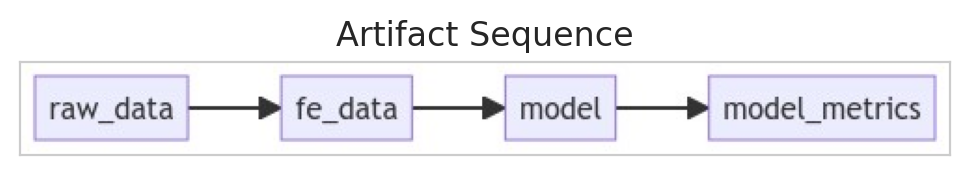

In [13]:
graph = """
graph LR;
RD[raw_data] --> FD[fe_data]
FD --> M[model]
M --> MM[model_metrics]
"""

flowchart(graph, 200, 'Artifact Sequence')

## Part 2: Create Reusable Components

During the model development process, there are many reasons to modify the above code, such as
* Using different data and redoing the end-to-end process to adapt more realistic cases.
* Using different feature sets to improve the model.
* Training different models to find the best model.
* Using different metrics to align with business objectives.

The conventional wisdom for the user to achieve these goals are
* At the early stage of development, data scientists will make several copies of the notebook and make some changes here and there; they eventually lose track of the notebook.
* At the later stage of the development, data engineers will refactor the code as a standalone module and share the library across the team. The module becomes very rigid and slow-moving if any changes need to happen so that data scientists will go back to the notebook copying path again.

`LineaPy` provides two methods to reuse the workflow from their notebook. There is no need to duplicate the notebook endlessly but still keep the development process flexible enough. 


### 1. Reusable component as a Python function. 

`LineaPy` can generate a parameterized workflow that calculates the list of variables(previously registered as artifacts) as a Python function.
This can be achieved by specifying a list of input variables users want to parameterize and the list of artifacts(checkpoints) they want to recompute to `lineapy.get_function(artifacts, input_parameters)` API.

Let's say we want to train a stochastic gradient descent(SGD) model and use minimal accuracy as our metric to evaluate the model. 
We can achieve this by following code

In [14]:
# NBVAL_IGNORE_OUTPUT
# Want to use different model and evaluate with different scoring metric.

calculate_metrics = lineapy.get_function(
  artifacts=["model_metrics"], 
  input_parameters=["import_module","model_name","scoring","cv_scoring_metric_name"], 
)

sgd_metrics = calculate_metrics(
    import_module='sklearn.linear_model', 
    model_name='SGDClassifier', 
    scoring='accuracy', 
    cv_scoring_metric_name='min'
)
sgd_metrics

{'model_metrics': {'accuracy': 90.87878787878788,
  'cv_scores': array([0.9238806 , 0.92238806, 0.91343284, 0.90447761, 0.91791045,
         0.92238806, 0.91791045, 0.89552239, 0.94029851, 0.9238806 ]),
  'cv_scoring_metric': 0.8955223880597015}}

### 2. Reusable components as a Python module. 

`LineaPy` can also create a Python module that includes several functions, and each function is responsible for calculating one artifact or common objects of multiple artifacts.
To be more specific, we've saved four artifacts(`raw_data`, `featured_data`, ` model`, `metric`) in our example workflow, and we might want to 
1. change the `url`, so we can train the model with different data,
1. change the `import_module` and `model_name` so we can train different models,
1. change the `scoring` and `cv_scoring_metric_name` so we use a different metric to evaluate the model performance.

These can be achieved by `lineapy.get_module` API as following

In [15]:
helper_module = lineapy.get_module(
  ["raw_data","fe_data","model","model_metrics"], 
  input_parameters=["url","import_module","model_name","scoring","cv_scoring_metric_name"],   
)

If we investigate objects within the module, we can see some function starts with *get_* and ends with the artifact name like

In [16]:
helper_module_text = lineapy.get_module_definition(
  ["raw_data","fe_data","model","model_metrics"], 
  input_parameters=["url","import_module","model_name","scoring","cv_scoring_metric_name"],   
)
print(helper_module_text)

import argparse
import importlib
import importlib.util
from importlib.abc import Loader

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.svm import SVC


def get_raw_data(url):
    sdss_df = pd.read_csv(url)
    return sdss_df


def get_fe_data(sdss_df):
    sdss_df_fe = sdss_df.drop(
        ["objid", "run", "rerun", "camcol", "field", "specobjid"], axis=1
    )
    le = LabelEncoder()
    y_encoded = le.fit_transform(sdss_df_fe["class"])
    sdss_df_fe["class"] = y_encoded
    pca = PCA(n_components=3)
    ugriz = pca.fit_transform(sdss_df_

#### What Is Happening Here?

Dependent on the user-selected list of artifacts, `LineaPy` can divide one computation graph(a representation of your code) into multiple non-overlapping subgraphs. 
Based on the user-selected list of input parameters, `LineaPy` can also parametrize the workflow.

```
lineapy.get_module(
  ["raw_data","fe_data","model","model_metrics"], 
  input_parameters=["url","import_module","model_name","scoring","cv_scoring_metric_name"],   
)
```

In this case, we are expecting `get_raw_data()`, `get_fe_data()`, `get_model()`, and `get_model_metrics()` four functions, and each one corresponds to an artifact. 
However, we can see one extra function, `get_x_test_x_train_y_test_y_train_for_artifact_model_and_downstream()`, shows up in the module file as well.
The reason is that `X_train` and `y_train` are used in both `get_model()` and `get_model_metrics()`; furthermore, `X_test`, `X_train`, `y_test` and `y_train` are created at the same statement.
Since `LineaPy` break up the code in a non-overlapping way; thus, we are seeing an extra `get_x_test_x_train_y_test_y_train_for_artifact_model_and_downstream()` function shows up here.


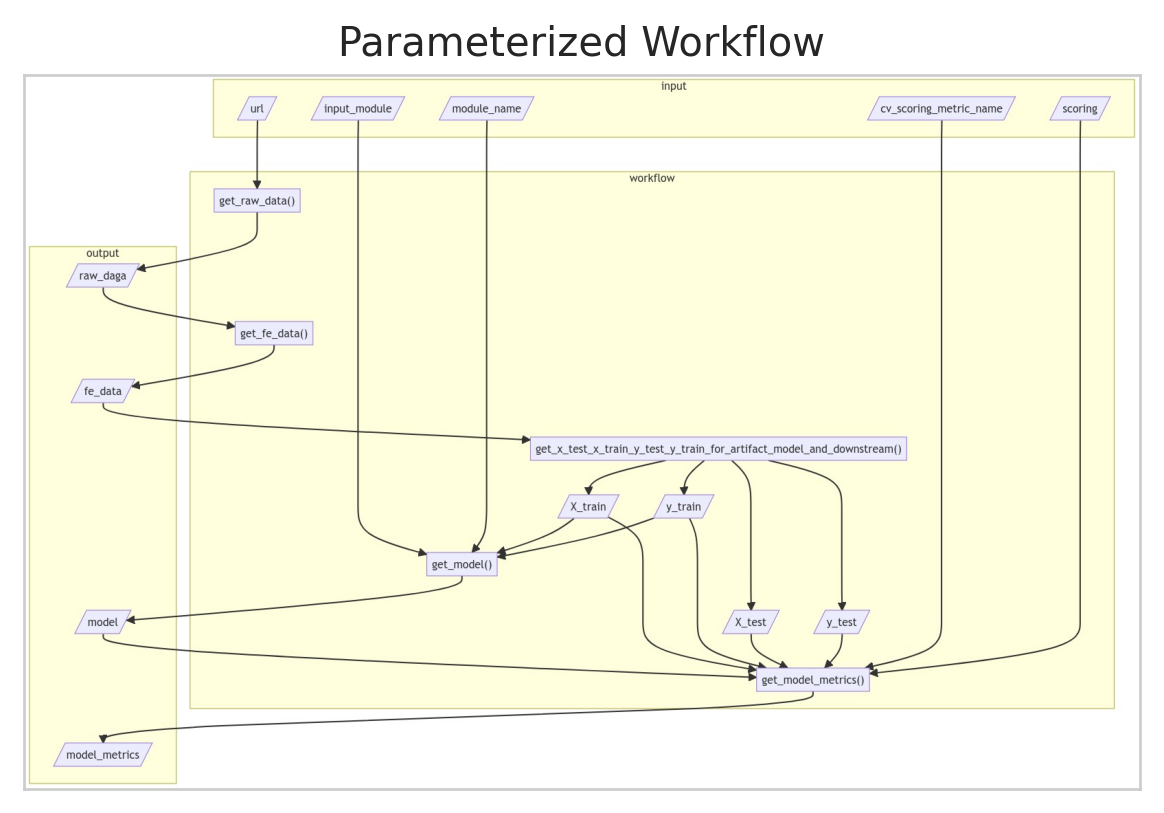

In [17]:
graph = """
graph

subgraph input
url[/url/]
im[/input_module/]
mn[/module_name/]
s[/scoring/]
csmn[/cv_scoring_metric_name/]
end 

subgraph workflow
GRD["get_raw_data()"] 
GFD["get_fe_data()"]
GXXYY["get_x_test_x_train_y_test_y_train_for_artifact_model_and_downstream()"]
GM["get_model()"]
GMM["get_model_metrics()"]
xtr[/X_train/]
ytr[/y_train/]
xte[/X_test/]
yte[/y_test/]
end

subgraph output
rd[/raw_daga/]
fd[/fe_data/]
m[/model/]
mm[/model_metrics/]
end

url --> GRD
GRD --> rd 
rd --> GFD
GFD --> fd
fd --> GXXYY
GXXYY --> xtr & ytr & xte & yte
im & mn & xtr & ytr --> GM
GM --> m
xtr & ytr & xte & yte & csmn & s & m --> GMM
GMM --> mm
"""

flowchart(graph, 240, 'Parameterized Workflow')

#### Reuse Functions within the Module

After investigating all the function definitions within the module, we can reuse these functions individually to achieve more than the parameterization described in the previous example.
For instance, we want to use `keras` to train a three-layer dense neural network model with different dropout rates on the same training data set and features. 

#### Reuse Functions to Load Data

Here, we can reuse `get_raw_data()`, `get_fe_data()`, and `get_x_test_x_train_y_test_y_train_for_artifact_model_and_downstream()` to prepare the same training and validation data set as before.

In [18]:
# Load raw data from artifact store
url = "https://raw.githubusercontent.com/LineaLabs/lineapy/main/examples/use_cases/creating_reusable_components/data/Skyserver_SQL2_27_2018%206_51_39%20PM.csv" 
new_raw_data = helper_module.get_raw_data(url)

# Do some tweak on the feature engineering 
new_fe_data = helper_module.get_fe_data(new_raw_data)
new_X_test, new_X_train, new_y_test, new_y_train = helper_module.get_x_test_x_train_y_test_y_train_for_artifact_model_and_downstream(new_fe_data)

#### Train a Keras Model

In [19]:
# NBVAL_IGNORE_OUTPUT
import tensorflow as tf
from tensorflow import keras
import lineapy

# Here are we are not using cross validation but using a hold out set for validation during the training
XTrain, XVal, YTrain, YVal = train_test_split(new_X_train, new_y_train, test_size = 0.1, random_state=101)

# We might want to tune the dropout rate between different layer 
dropout1 = 0.25
dropout2 = 0.25
dropout3 = 0.5

# Construct the model
kmodel = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(dropout1),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(dropout2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(dropout3),
    keras.layers.Dense(3, activation='softmax')
])
# Set opimizer
optimizer = tf.keras.optimizers.RMSprop()
# Compile the model
kmodel.compile(optimizer=optimizer , loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Set training parameters
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(
    monitor='accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)
# Train the model
history = kmodel.fit(
    XTrain, YTrain,
    batch_size=86,
    epochs = 30,
    validation_data = (XVal,YVal),
    verbose=0,
    callbacks=[learning_rate_reduction]
)

print(kmodel.summary())

# Save trained model as artifact
lineapy.save(kmodel, 'nn_model')

2023-01-30 12:10:21.621262: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-30 12:10:21.740631: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-30 12:10:21.740648: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-30 12:10:22.332167: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 9)                 0         
                                                                 
 dense (Dense)               (None, 256)               2560      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

LineaArtifact(name='nn_model', _version=8)

#### Evaluate the model performance

Now we can evaluate our neural network model performance.

In [20]:
# NBVAL_IGNORE_OUTPUT

results = kmodel.predict(X_test)
evaluation_result = kmodel.evaluate(X_test, y_test)

# Save metric as an artifact
art = lineapy.save(evaluation_result, 'nn_model_evaluation')
print(evaluation_result)

104/104 [==============================] - 0s 835us/step - loss: 0.0923 - accuracy: 0.9755
[0.09232450276613235, 0.975454568862915]


## Recap

In this tutorial, we've 
1. used a machine learning model developing example to demonstrate how to save artifacts as checkpoints and create reusable functions and modules to reuse the workflow,
1. explained how these reusable components are created
1. demonstrated how to use these reusable components in two different ways.

These reusable components can help individual users with
1. organizing their development and experiments

These reusable components can help organizations with
1. sharing work between teammates
1. deploying standardized components within the organization



## What Next

<div class="admonition info" style="background:#F0FAFA">
    <p class="admonition-title"><b>Info</b></p>
    <p>
        If you want to learn more about LineaPy's pipeline support, check out the project <a href="https://docs.lineapy.org/latest/guides/usage/pipeline-building/">documentation</a>.
    </p>
</div>